# Gaussian Mixture Models Implementation
Oscar Contreras Carrasco

Hi everyone! This is a full implementation of Gaussian Mixture Models in Python. I really hope you will find it useful to further understand how the algorithm works.

Let's first import the libraries we are going to be using throughout the exercise:

In [483]:
import imageio
import matplotlib.animation as ani
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.patches import Ellipse
from PIL import Image
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

For the purposes of this exercise, we will be using the Iris dataset, which is probably already familiar to you. We can easily obtain it by using the __load_iris__ function provided by sklearn:

In [2]:
iris = datasets.load_iris()
X = iris.data
X[:20]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3]])

Let us now implement the Gaussian density function. Ahem... I know you can use numpy functions for that, but I believe it is actually interesting to see how things work internally. Our aim is to create a function that implements this:

\begin{equation}
\large
p(\mathbf x | \mathbf\mu, \mathbf\Sigma) = \frac 1 {({2\pi})^{n/2}|\Sigma|^{1/2}}\exp\left(-\frac 1 2 (\mathbf x -\mathbf\mu)^T\mathbf\Sigma^{-1}(\mathbf x -\mathbf\mu)\right)
\end{equation}


In [446]:
def gaussian(X, mu, cov):
    
        
    vals, vecs = np.linalg.eig(cov)
    
    vecs = vecs[:,np.argsort(-vals)][:,:20]
    vals = vals[np.argsort(-vals)][:20]
    from scipy.spatial import distance
    
    X= X.dot(vecs)

    mu = vecs.T.dot(mu)

    sum_all = 0
    for i in range(20):
        c = X[:,i]-mu[i]
        sum_all += c**2/vals[i]

        
    a = 1 / np.sqrt(sum(vals)) * np.exp(-0.5*sum_all ).reshape(-1, 1)
    return a.real

You can try this function by using the code in next cell. You should obtain something like:

array([[0.00159853],
       [0.00481869],
       [0.00276259],
       [0.0014309 ],
       [0.00143998]])

In [467]:
x0 = np.array([[0.05, 1.413, 0.212], [0.85, -0.3, 1.11], [11.1, 0.4, 1.5], [0.27, 0.12, 1.44], [88, 12.33, 1.44]])

mu = np.mean(data, axis=0)
print (mu.shape)
cov = np.cov(data,rowvar=False)
print (cov.shape)
print (data.shape)
y = gaussian(data, mu=mu, cov=cov)
y

(784,)
(784, 784)
(1990, 784)


array([[4.46747254e-07],
       [1.40895289e-08],
       [2.35105809e-05],
       ...,
       [2.94404920e-06],
       [2.34654549e-05],
       [4.68880378e-06]])

__Step 1__

This is the initialization step of the GMM. At this point, we must initialise our parameters $\pi_k$, $\mu_k$, and $\Sigma_k$. In this case, we are going to use the results of KMeans as an initial value for $\mu_k$, set $\pi_k$ to one over the number of clusters and $\Sigma_k$ to the identity matrix. We could also use random numbers for everything, but using a sensible initialisation procedure will help the algorithm achieve better results.

In [477]:
def initialize_clusters(X, n_clusters):
    clusters = []

    for i in range(n_clusters):
        clusters.append({
            'pi_k': 1.0 / n_clusters,
            'mu_k': np.random.normal(0, 0.1, 784),
            'cov_k': np.identity(X.shape[1], dtype=np.float64)
        })
    return clusters

**Step 2 (Expectation step)**

We should now calculate $\gamma(z_{nk})$. We can achieve this by means of the following expression:

\begin{equation}
\large
\gamma{(z_{nk})}=\frac {\pi_k\mathcal N(\mathbf x_n| \mathbf\mu_k, \mathbf\Sigma_k)}{\sum_{j=1}^K\pi_j\mathcal N(\mathbf x_n| \mathbf\mu_j, \mathbf\Sigma_j)}
\end{equation}

For convenience, we just calculate the denominator as a sum over all terms in the numerator, and then assign it to a variable named __totals__

In [456]:
def expectation_step(X, clusters):
    totals = np.zeros((X.shape[0], 1), dtype=np.float64)
    
    for cluster in clusters:
        pi_k = cluster['pi_k']
        mu_k = cluster['mu_k']
        cov_k = cluster['cov_k']
        
        gamma_nk = (pi_k * gaussian(X, mu_k, cov_k)).astype(np.float64)
        
        for i in range(X.shape[0]):
            totals[i] += gamma_nk[i]
        
        cluster['gamma_nk'] = gamma_nk
        cluster['totals'] = totals
        
    
    for cluster in clusters:
        cluster['gamma_nk'] /= cluster['totals']

**Step 3 (Maximization step):**

Let us now implement the maximization step. Since $\gamma(z_{nk})$ is common to the expressions for $\pi_k$, $\mu_k$ and $\Sigma_k$, we can simply define:

\begin{equation}
\large
N_k=\sum_{n=1}^N\gamma({z_{nk}})
\end{equation}

And then we can calculate the revised parameters by using:

\begin{equation}
\large
\pi_k^*=\frac {N_k} N
\end{equation}


\begin{equation}
\large
\mu_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})\mathbf x_n
\end{equation}


\begin{equation}
\large
\Sigma_k^*=\frac 1 {N_k} \sum_{n=1}^N\gamma({z_{nk}})(\mathbf x_n-\mathbf\mu_k)(\mathbf x_n-\mathbf\mu_k)^T
\end{equation}

Note: To calculate the covariance, we define an auxiliary variable __diff__ that contains $(x_n-\mu_k)^T$.

In [457]:
def maximization_step(X, clusters):
    N = float(X.shape[0])
  
    for cluster in clusters:
        gamma_nk = cluster['gamma_nk']
        cov_k = np.zeros((X.shape[1], X.shape[1]))
        
        N_k = np.sum(gamma_nk, axis=0)
        
        pi_k = N_k / N
        mu_k = np.sum(gamma_nk * X, axis=0) / N_k
        
        for j in range(X.shape[0]):
            diff = (X[j] - mu_k).reshape(-1, 1)
            cov_k += gamma_nk[j] * np.dot(diff, diff.T)
            
        cov_k /= N_k
        
        cluster['pi_k'] = pi_k
        cluster['mu_k'] = mu_k
        cluster['cov_k'] = cov_k

Let us now determine the log-likelihood of the model. It is given by:

\begin{equation}
\large
\ln p(\mathbf X)=\sum_{n=1}^N\ln\sum_{k=1}^K\pi_k\mathcal N(\mathbf x_n|\mu_k,\Sigma_k)
\end{equation}

However, the second summation has already been calculated in the __expectation_step__ function and is available in the __totals__ variable. So we just make use of it.

In [479]:
def get_likelihood(X, clusters):
    likelihood = []
    sample_likelihoods = -np.log(np.array([cluster['totals'] for cluster in clusters]))
    return np.sum(sample_likelihoods), sample_likelihoods

Finally, let's put everything together! First, we are going to initialise the parameters by using the __initialise_clusters__ function, and then perform several expectation-maximization steps. In this case, we set the number of iterations of the training procedure to a fixed __n_epochs__ number. I have done this on purpose to generate graphs of the log-likelihood later.

In [480]:
def train_gmm(X, n_clusters, n_epochs):
    clusters = initialize_clusters(X, n_clusters)
    likelihoods = np.zeros((n_epochs, ))
    scores = np.zeros((X.shape[0], n_clusters))
    history = []

    for i in range(n_epochs):
        clusters_snapshot = []
        
        # This is just for our later use in the graphs
        for cluster in clusters:
            clusters_snapshot.append({
                'mu_k': cluster['mu_k'].copy(),
                'cov_k': cluster['cov_k'].copy()
            })
            
        history.append(clusters_snapshot)
      
        expectation_step(X, clusters)
        maximization_step(X, clusters)

        likelihood, sample_likelihoods = get_likelihood(X, clusters)
        likelihoods[i] = likelihood

        print('Epoch: ', i + 1, 'Likelihood: ', likelihood)
        
    for i, cluster in enumerate(clusters):
        scores[:, i] = np.log(cluster['gamma_nk']).reshape(-1)
        
    return clusters, likelihoods, scores, sample_likelihoods, history

Let's train our model!

In [481]:
n_clusters = 2
n_epochs = 20
data = np.asarray( pd.read_csv("data.dat", sep='\s+',header=None)).T
clusters, likelihoods, scores, sample_likelihoods, history = train_gmm(data, n_clusters, n_epochs)

[{'pi_k': 0.5, 'mu_k': array([ 1.35474225e-02, -1.69573843e-02, -4.82401010e-03,  1.42025837e-01,
        1.35989609e-01,  2.16572054e-02,  2.02391586e-02,  1.27354511e-01,
       -1.02979086e-01, -7.08958907e-02, -1.48382799e-01,  1.52041611e-01,
        7.03889859e-02,  4.88023339e-02, -1.42209412e-01,  5.52692782e-02,
       -1.74303478e-01,  9.42218275e-02, -1.26795384e-02,  6.51916651e-02,
       -2.27980920e-02,  9.14182088e-02,  1.67279363e-01, -2.60765314e-02,
        1.80765944e-01,  1.53105336e-01,  6.05485574e-02, -1.29823396e-01,
        1.50007697e-01,  1.47752660e-01,  7.61901876e-02, -2.16250788e-02,
        1.01648871e-01,  6.71844297e-02, -9.40525402e-02,  2.18733558e-01,
       -1.40012804e-02, -5.50470722e-02, -1.05572541e-01,  4.64120196e-02,
        2.23072487e-01, -3.23454997e-02, -1.70779784e-01, -3.66859885e-02,
        1.69006980e-02,  1.93282031e-01,  1.27117813e-02,  3.83379973e-02,
        2.32804183e-02, -5.33637378e-03, -1.11443731e-02,  4.67819416e-02,
  

Epoch:  1 Likelihood:  15529.69528838536
Epoch:  2 Likelihood:  46816.88131344268


KeyboardInterrupt: 

It is always a good idea to see how the log-likelihood is making progress. So let's create a graph reflecting that value

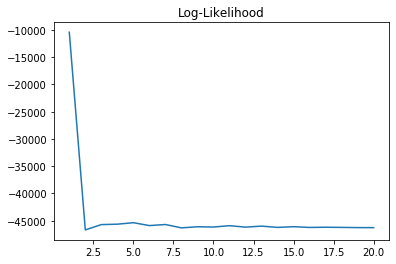

In [486]:

sns.lineplot(np.arange(1, n_epochs + 1), likelihoods)
plt.title('Log-Likelihood')
plt.show()

Let us now create a graph to visualise our clusters as well as the parameters for the Gaussian mixture. Essentially, what we do here is to create ellipses of different scales in order to map to the coordinates of each Gaussian.

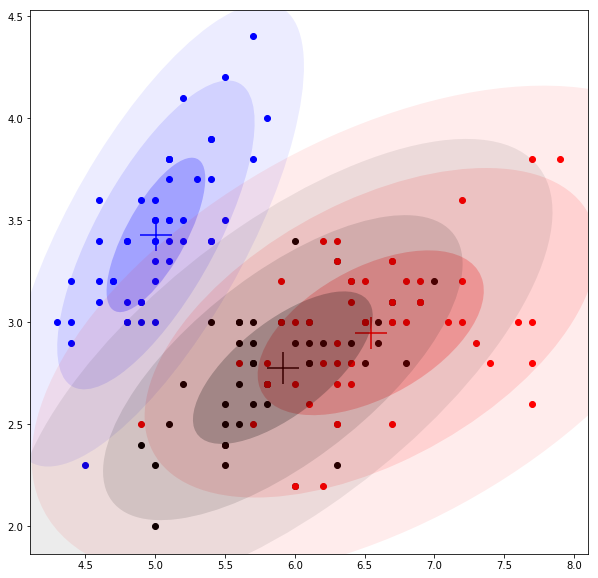

In [12]:
def create_cluster_animation(X, history, scores):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    colorset = ['blue', 'red', 'black']
    images = []
    
    for j, clusters in enumerate(history):
      
        idx = 0
      
        if j % 3 != 0:
            continue
        
        plt.cla()
        
        for cluster in clusters:
            mu = cluster['mu_k']
            cov = cluster['cov_k']

            eigenvalues, eigenvectors = np.linalg.eigh(cov)
            order = eigenvalues.argsort()[::-1]
            eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
            vx, vy = eigenvectors[:,0][0], eigenvectors[:,0][1]
            theta = np.arctan2(vy, vx)

            color = colors.to_rgba(colorset[idx])

            for cov_factor in range(1, 4):
                ell = Ellipse(xy=mu, width=np.sqrt(eigenvalues[0]) * cov_factor * 2, height=np.sqrt(eigenvalues[1]) * cov_factor * 2, angle=np.degrees(theta), linewidth=2)
                ell.set_facecolor((color[0], color[1], color[2], 1.0 / (cov_factor * 4.5)))
                ax.add_artist(ell)

            ax.scatter(cluster['mu_k'][0], cluster['mu_k'][1], c=colorset[idx], s=1000, marker='+')
            idx += 1

        for i in range(X.shape[0]):
            ax.scatter(X[i, 0], X[i, 1], c=colorset[np.argmax(scores[i])], marker='o')
        
        fig.canvas.draw()
        
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        images.append(image)
    
    kwargs_write = {'fps':1.0, 'quantizer':'nq'}
    imageio.mimsave('./gmm.gif', images, fps=1)
    plt.show(Image.open('gmm.gif').convert('RGB'))
    
    
create_cluster_animation(X, history, scores)

By the way, you can also watch an animation of how the cluster estimations improve. You can just open the __gmm.gif__ file generated. Let's now test if our calculations are correct. In this case, we are using sklearn's GMM implementation to check for the parameters and probabilities.

In [20]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=n_clusters, max_iter=50).fit(data)
gmm_scores = gmm.score_samples(data)

print('Means by sklearn:\n', gmm.means_)

print('Scores by sklearn:\n', gmm_scores[0:20])


Means by sklearn:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Scores by sklearn:
 [2137.07505529 2193.56593623 2228.22036869 2225.15699639 2169.61329957
 2213.9635641  2058.80282557 2282.18502994 2182.30389046 2154.23969504
 2184.57921409 2126.05681514 2183.19561748 2248.66883676 2267.11378643
 2307.81135386 2292.94440633 2209.00662836 2122.91255205 2233.30558984]
